#Imports

In [1]:
# !pip install tensorflow==2.13.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


#Loading and Preparing Data

                     Consumption  Production  Nuclear  Wind  Hydroelectric  \
DateTime                                                                     
2019-01-01 00:00:00         6352        6527     1395    79           1383   
2019-01-01 01:00:00         6116        5701     1393    96           1112   
2019-01-01 02:00:00         5873        5676     1393   142           1030   
2019-01-01 03:00:00         5682        5603     1397   191            972   
2019-01-01 04:00:00         5557        5454     1393   159            960   

                     Oil and Gas  Coal  Solar  Biomass  
DateTime                                                
2019-01-01 00:00:00         1896  1744      0       30  
2019-01-01 01:00:00         1429  1641      0       30  
2019-01-01 02:00:00         1465  1616      0       30  
2019-01-01 03:00:00         1455  1558      0       30  
2019-01-01 04:00:00         1454  1458      0       30  


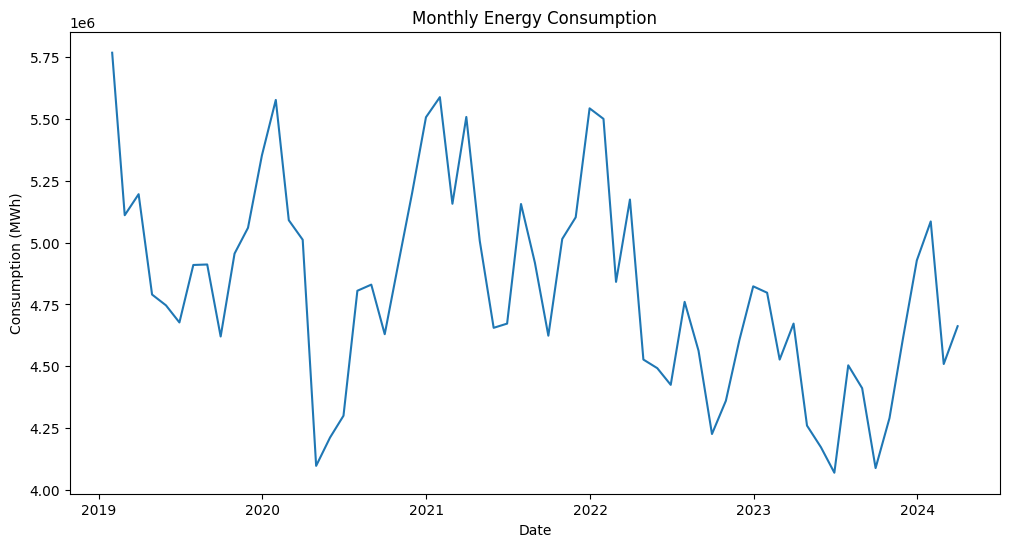

In [3]:
#file path from Google Drive
file_path = '/content/drive/My Drive/Projects/Energy_prediction_system/Dataset/data.csv'

#DateTime column parsed and set as the index
data = pd.read_csv(file_path, parse_dates=['DateTime'], index_col='DateTime')
print(data.head())

#Aggregating Consumption to monthly sums for forecasting
data_monthly = data['Consumption'].resample('ME').sum()

#plotting the result to visualize trends.
plt.figure(figsize=(12,6))
plt.plot(data_monthly)
plt.title('Monthly Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (MWh)')
plt.show()

# Exploratory Data Analysis(EDA)

Missing values: 0


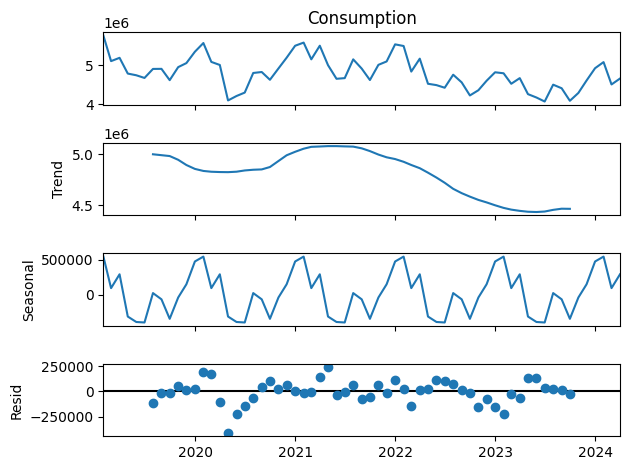


ADF Statistic: -3.3514171574977913
The series is stationary.


In [8]:
#Checking for missing values
print("Missing values:", data_monthly.isnull().sum())

#Decomposing the time series to identify trends and seasonality
decomposition = seasonal_decompose(data_monthly, model='additive', period=12)
decomposition.plot()
plt.show()

#Testing for stationarity using the Augmented Dickey-Fuller test
result = adfuller(data_monthly)
data_diff= data_monthly.diff().dropna()
data_seasonal_diff = data_diff.diff(12).dropna()

result_seasonal_diff = adfuller(data_seasonal_diff)
print('\nADF Statistic:', result_seasonal_diff[0])

if result_seasonal_diff[1] > 0.05:
    print("The series is not stationary. Consider differencing.")
else:
    print("The series is stationary.")

#Building and Evaluating Models

#For ARIMA

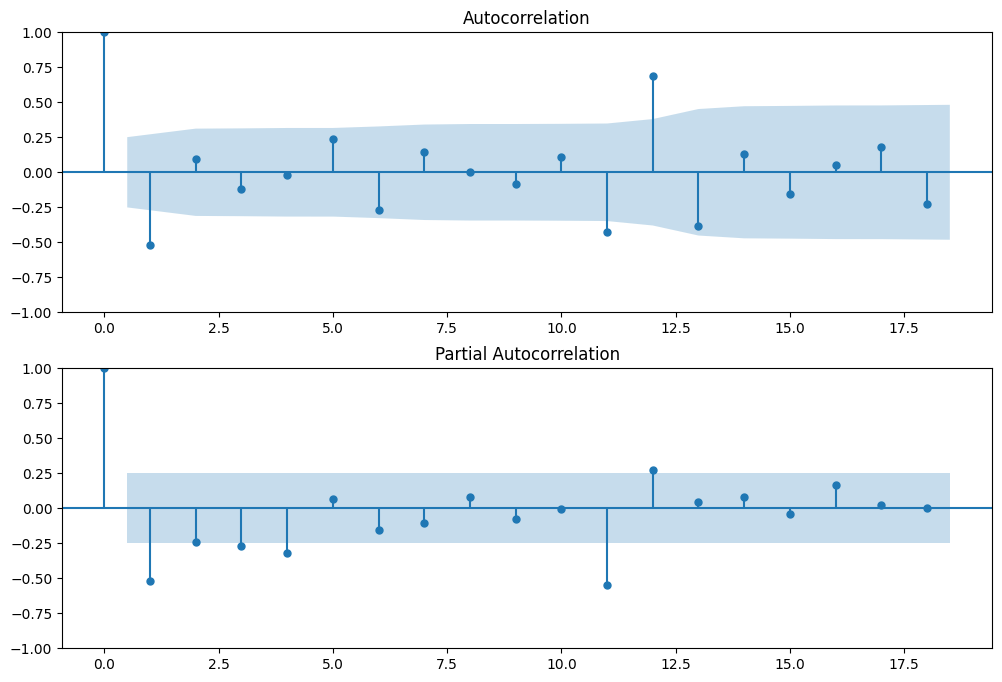

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(data_diff, ax=ax1)
plot_pacf(data_diff, ax=ax2)
plt.show()

ARIMA - MAE: 907505.3256658628, RMSE: 959582.4417413037


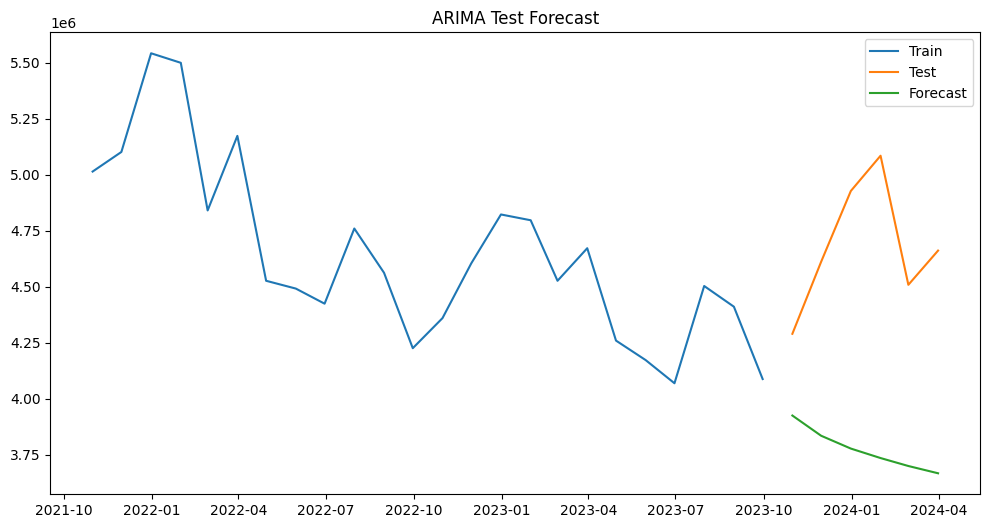

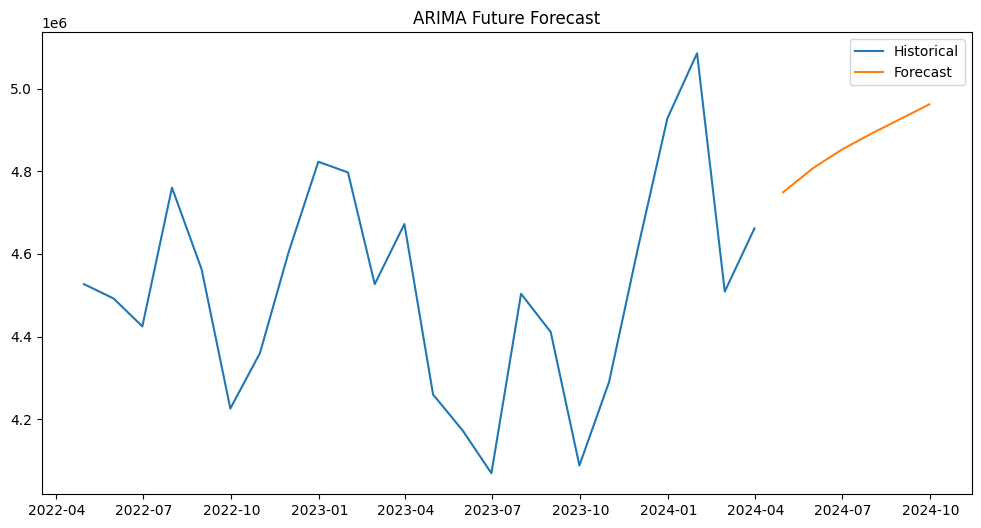

In [ ]:
#Splitting data into train and test data
train_data = data_monthly[:-6]
test_data = data_monthly[-6:]

#Training the model
model_arima_train = ARIMA(train_data, order=(1,2,1))
arima_result_train = model_arima_train.fit()
forecast_arima_test = arima_result_train.forecast(steps=6)
mae_arima = mean_absolute_error(test_data, forecast_arima_test)
rmse_arima = np.sqrt(mean_squared_error(test_data, forecast_arima_test))
print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}")

#Plotting
plt.figure(figsize=(12,6))
plt.plot(train_data[-24:], label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_data.index, forecast_arima_test, label='Forecast')
plt.title('ARIMA Test Forecast')
plt.legend()
plt.show()

#Predicting Future forecast
model_arima = ARIMA(data_monthly, order=(1,2,1))
arima_result = model_arima.fit()
forecast_arima_future = arima_result.forecast(steps=6)
future_dates = pd.date_range(start=data_monthly.index[-1], periods=7, freq='ME')[1:]


plt.figure(figsize=(12,6))
plt.plot(data_monthly[-24:], label='Historical')
plt.plot(future_dates, forecast_arima_future, label='Forecast')
plt.title('ARIMA Future Forecast')
plt.legend()
plt.show()

# FOR SARIMA

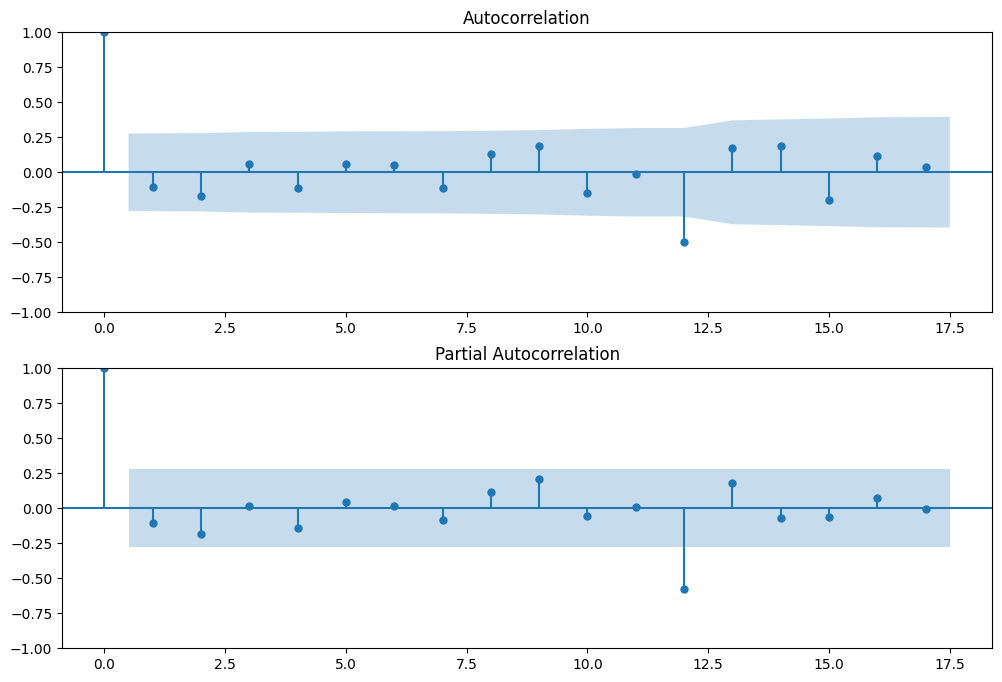

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(data_seasonal_diff, ax=ax1)
plot_pacf(data_seasonal_diff, ax=ax2)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


SARIMA - MAE: 188011.53859877758, RMSE: 222259.40962767514
ARIMA - MAE: 907505.3256658628, RMSE: 959582.4417413037


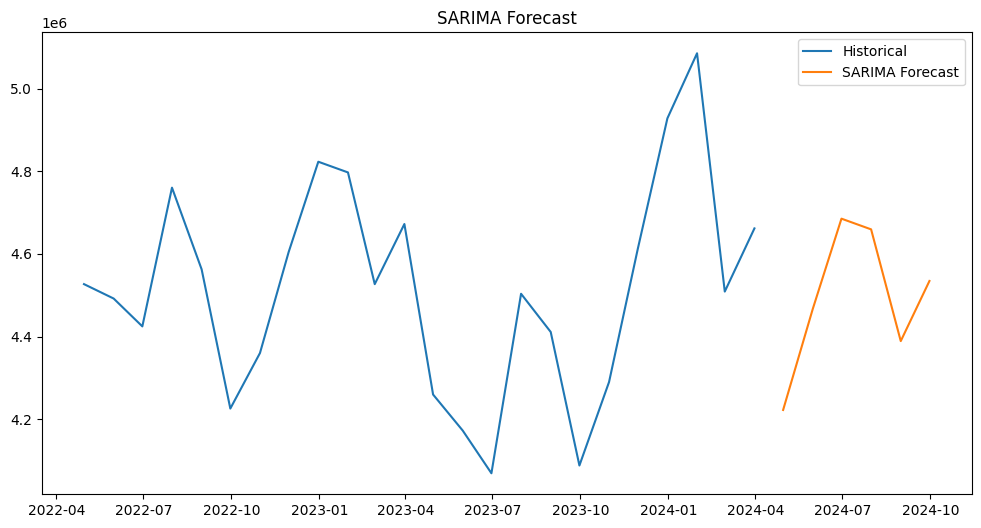

In [11]:
# Define train and test sets (last 6 months for test)
train_data = data_monthly[:-6]
test_data = data_monthly[-6:]

# Fit SARIMA model
model_sarima = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
sarima_result = model_sarima.fit()

# Forecast test data
forecast_sarima_test = sarima_result.forecast(steps=6)

# Calculate metrics
mae_sarima = mean_absolute_error(test_data, forecast_sarima_test)
rmse_sarima = np.sqrt(mean_squared_error(test_data, forecast_sarima_test))
print(f"SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}")

# Compare with ARIMA
print(f"ARIMA - MAE: 907505.3256658628, RMSE: 959582.4417413037")

# Forecast future 6 months for visualization
future_forecast_sarima = sarima_result.forecast(steps=6)
future_dates = pd.date_range(start=data_monthly.index[-1], periods=7, freq='ME')[1:]

# Plot historical and forecast
plt.figure(figsize=(12,6))
plt.plot(data_monthly[-24:], label='Historical')
plt.plot(future_dates, future_forecast_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

#For LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - loss: 0.2584 - val_loss: 0.1522
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2480 - val_loss: 0.1419
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2259 - val_loss: 0.1320
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2022 - val_loss: 0.1222
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1919 - val_loss: 0.1125
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1746 - val_loss: 0.1026
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1504 - val_loss: 0.0926
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1361 - val_loss: 0.0823
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1310 - val_loss: 0.0718
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0967 - val_loss: 0.0611
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0962 - val_loss: 0.0503
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0815 - val_lo

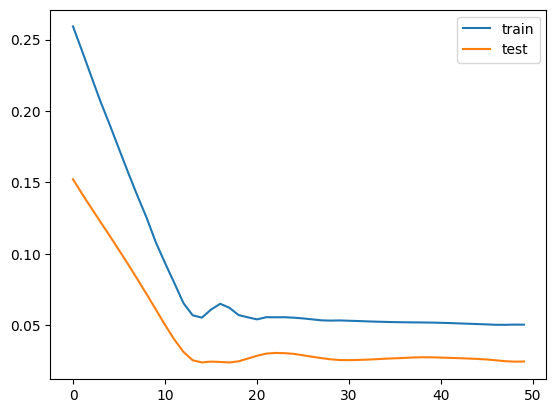

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
LSTM - MAE: 211482.33333333334, RMSE: 266833.500208151


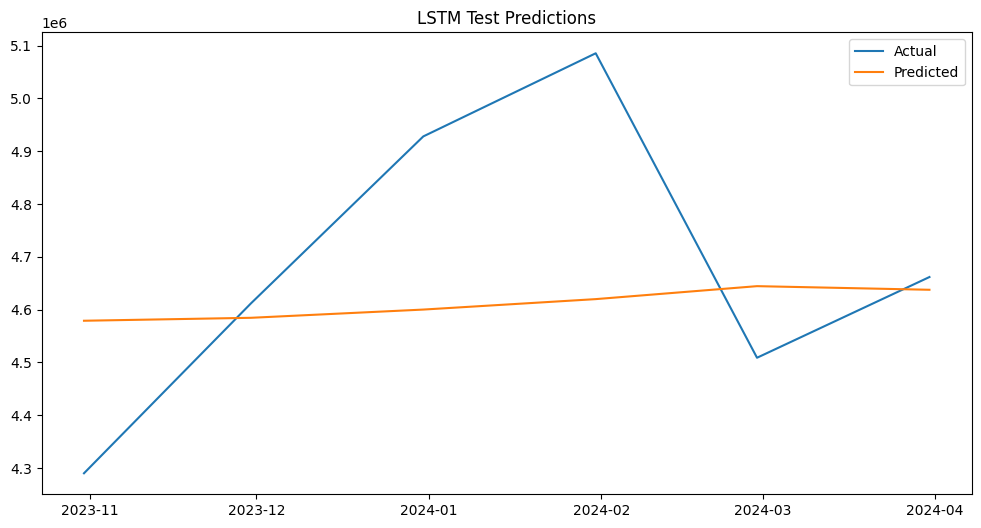

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


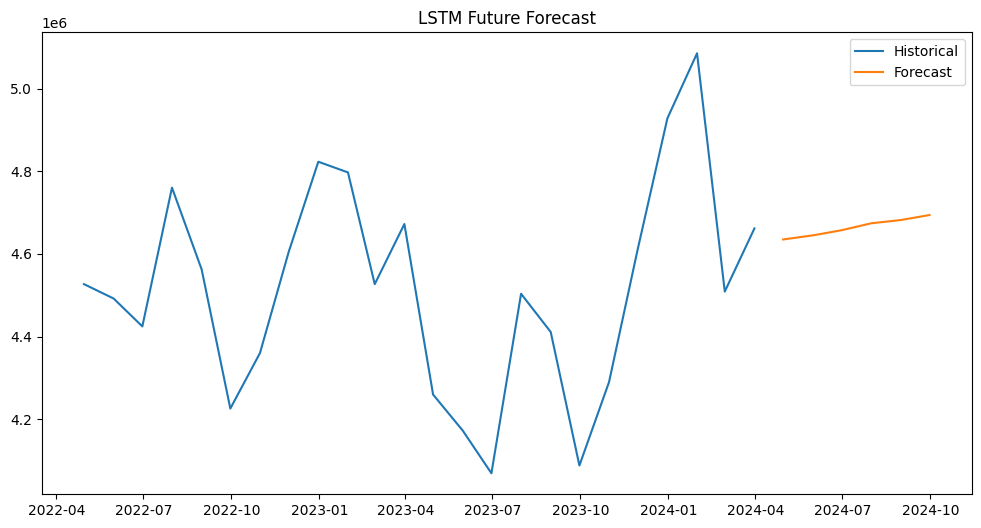

In [12]:
#scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_monthly.values.reshape(-1,1))

#creating sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

#plitting into train and test data
train_size = len(X) - 6
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
#reshaping for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#training the model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#Evaluating on the last 6 month
y_pred = model_lstm.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM - MAE: {mae_lstm}, RMSE: {rmse_lstm}")

plt.figure(figsize=(12,6))
plt.plot(data_monthly.index[-6:], y_test_inv, label='Actual')
plt.plot(data_monthly.index[-6:], y_pred_inv, label='Predicted')
plt.title('LSTM Test Predictions')
plt.legend()
plt.show()

#forecasting future consumption
last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)
future = []
for _ in range(6):
    next_pred = model_lstm.predict(last_sequence)
    future.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_pred[0, 0]
future_inv = scaler.inverse_transform(np.array(future).reshape(-1,1))
future_dates = pd.date_range(start=data_monthly.index[-1], periods=7, freq='ME')[1:]

plt.figure(figsize=(12,6))
plt.plot(data_monthly[-24:], label='Historical')
plt.plot(future_dates, future_inv, label='Forecast')
plt.title('LSTM Future Forecast')
plt.legend()
plt.show()